In [1]:
# Kaggle-stable cleaner: copy -> re-encode -> prune -> build lists
import os, glob, shutil, cv2, numpy as np
from PIL import Image, ImageFile
from tqdm.auto import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

SRC = "/kaggle/input/firedetection/archive (4)/data"
DST = "/kaggle/working/clean_data"
LIST_DIR = "/kaggle/working/lists"

# fresh outputs
if os.path.exists(DST): shutil.rmtree(DST)
for s in ["train","val","test"]:
    os.makedirs(os.path.join(DST, s, "images"), exist_ok=True)
    os.makedirs(os.path.join(DST, s, "labels"), exist_ok=True)
os.makedirs(LIST_DIR, exist_ok=True)

def read_ok(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    if im is not None and im.size > 0: return im
    try:
        with Image.open(path) as p:
            p = p.convert("RGB")
            return np.array(p)[:, :, ::-1]
    except Exception:
        pass
    try:
        with open(path, "rb") as f:
            raw = np.frombuffer(f.read(), dtype=np.uint8)
        im2 = cv2.imdecode(raw, cv2.IMREAD_COLOR)
        if im2 is not None and im2.size > 0: return im2
    except Exception:
        pass
    return None

def copy_split(split):
    src_img = os.path.join(SRC, split, "images")
    src_lbl = os.path.join(SRC, split, "labels")
    dst_img = os.path.join(DST, split, "images")
    dst_lbl = os.path.join(DST, split, "labels")
    kept = dropped = 0

    for ip in tqdm(sorted(glob.glob(os.path.join(src_img, "*"))), desc=f"Copy {split}"):
        stem = os.path.splitext(os.path.basename(ip))[0]
        im = read_ok(ip)
        if im is None:
            dropped += 1
            # (don't copy its label)
            continue
        out_img = os.path.join(dst_img, stem + ".jpg")  # standardize to .jpg
        cv2.imwrite(out_img, im, [int(cv2.IMWRITE_JPEG_QUALITY), 92])

        lp_src = os.path.join(src_lbl, stem + ".txt")
        lp_dst = os.path.join(dst_lbl, stem + ".txt")
        if os.path.exists(lp_src):
            shutil.copy2(lp_src, lp_dst)
        else:
            open(lp_dst, "w").close()
        kept += 1
    return kept, dropped

stats = {s: copy_split(s) for s in ["train","val","test"]}
print("Re-encode stats (kept, dropped-unreadable):", stats)

# prune unreadables in clean copy, sync labels, and build lists
def prune_and_list(split):
    img_dir = os.path.join(DST, split, "images")
    lbl_dir = os.path.join(DST, split, "labels")
    kept_paths = []
    removed_images = removed_labels = 0

    # remove unreadable images + their labels
    for ip in sorted(glob.glob(os.path.join(img_dir, "*"))):
        base = os.path.splitext(os.path.basename(ip))[0]
        lp = os.path.join(lbl_dir, base + ".txt")
        im = cv2.imread(ip, cv2.IMREAD_COLOR)
        if (im is None) or (im.size == 0) or (os.path.getsize(ip) < 100):
            try: os.remove(ip); removed_images += 1
            except: pass
            if os.path.exists(lp):
                try: os.remove(lp); removed_labels += 1
                except: pass
        else:
            if not os.path.exists(lp):
                open(lp, "w").close()
            kept_paths.append(ip)

    # delete labels that don't have a matching image
    for lp in sorted(glob.glob(os.path.join(lbl_dir, "*.txt"))):
        base = os.path.splitext(os.path.basename(lp))[0]
        has_img = any(os.path.exists(os.path.join(img_dir, base + ext)) for ext in [".jpg",".jpeg",".png"])
        if not has_img:
            try: os.remove(lp); removed_labels += 1
            except: pass

    out_list = os.path.join(LIST_DIR, f"{split}.txt")
    with open(out_list, "w") as f:
        for p in kept_paths: f.write(p + "\n")

    print(f"{split}: kept={len(kept_paths)} | removed_images={removed_images} | removed_labels={removed_labels} | list={out_list}")
    return out_list

train_list = prune_and_list("train")
val_list   = prune_and_list("val")
test_list  = prune_and_list("test")

# sanity
assert os.path.getsize(train_list) > 0, "No readable train images after cleaning."
print("✅ Clean dataset & verified lists ready.")

Copy train:   0%|          | 0/14122 [00:00<?, ?it/s]

Copy val:   0%|          | 0/3098 [00:00<?, ?it/s]

Copy test:   0%|          | 0/4306 [00:00<?, ?it/s]

Re-encode stats (kept, dropped-unreadable): {'train': (14122, 0), 'val': (3098, 0), 'test': (4306, 0)}
train: kept=14122 | removed_images=0 | removed_labels=0 | list=/kaggle/working/lists/train.txt
val: kept=3098 | removed_images=0 | removed_labels=0 | list=/kaggle/working/lists/val.txt
test: kept=4306 | removed_images=0 | removed_labels=0 | list=/kaggle/working/lists/test.txt
✅ Clean dataset & verified lists ready.


In [2]:
# Install specific versions + train using file lists (no folder scanning)
!pip -q install ultralytics==8.3.225 opencv-python==4.8.1.78 pillow matplotlib

from ultralytics import YOLO
import torch, os, yaml

DATA_YAML = "/kaggle/working/data_lists.yaml"
with open(DATA_YAML, "w") as f:
    yaml.safe_dump({
        "path": "/kaggle/working/clean_data",  # optional context
        "train": train_list,                   # <-- VERIFIED file lists
        "val":   val_list,
        "test":  test_list,
        "names": {0: "fire", 1: "smoke"}      # adjust if your classes differ
    }, f, sort_keys=False)

os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
os.environ["WANDB_DISABLED"] = "true"

MODEL  = "yolov8n.pt"         # try 'yolov8s.pt' later for better accuracy
IMGSZ  = 640
EPOCHS = 50
BATCH  = 16
DEVICE = 0 if torch.cuda.is_available() else "cpu"

model = YOLO(MODEL)
results = model.train(
    
    data=DATA_YAML,
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    device=DEVICE,
    optimizer="Adam", lr0=1e-3,
    project="/kaggle/working/outputs",
    name="yolo_fire_verified",
    exist_ok=True,
    mosaic=0.0, mixup=0.0, erasing=0.0, auto_augment=None,
    amp=False,          # avoid AMP/image pre-check crashes
    workers=0,          # avoid FS/threading races on Kaggle
    cache=False         # don't write caches to readonly input mount
)

from pathlib import Path

# Correct way to display weight paths
print("✅ Training complete.")
print("Results directory:", results.save_dir)
print("Best weights:", results.save_dir / "weights" / "best.pt")
print("Last weights:", results.save_dir / "weights" / "last.pt")

# Optional: list the contents of the results folder
import os, glob
print("\nContents of results dir:")
for f in glob.glob(str(results.save_dir) + "/*"):
    print(" -", f)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curre

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       3098       3932      0.752      0.673      0.751      0.436
                  fire       1550       1756      0.784      0.738      0.805      0.498
                 smoke        879       2176       0.72      0.607      0.697      0.374
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/outputs/yolo_fire_verified
✅ Training complete.
Results directory: /kaggle/working/outputs/yolo_fire_verified
Best weights: /kaggle/working/outputs/yolo_fire_verified/weights/best.pt
Last weights: /kaggle/working/outputs/yolo_fire_verified/weights/last.pt

Contents of results dir:
 - /kaggle/working/outputs/yolo_fire_verified/train_batch35320.jpg
 - /kaggle/working/outputs/yolo_fire_verified/train_batch1.jpg
 - /kaggle/working/outputs/yolo_fire_verified/train_batch0.jpg
 - /kaggle/working/outputs/yolo_fire_verified/BoxPR_curve.png
 - /kaggle/working/outputs/yolo_fire_verified/results.png
 - /kaggle/working/outp

In [3]:
# Find best weights from our last run (fallbacks included)
import os, glob
cands = [
    "/kaggle/working/outputs/yolo_fire_verified/weights/best.pt",
    "/kaggle/working/outputs/yolo_fire_clean_from_src/weights/best.pt",
    "/kaggle/working/outputs/yolo_fire_clean_rebuild/weights/best.pt",
    "/kaggle/working/outputs/yolo_fire_autoscan/weights/best.pt",
    "/kaggle/working/outputs/yolo_fire_autosplit/weights/best.pt"
]
BEST = next((p for p in cands if os.path.exists(p)), None)
assert BEST, "Couldn't find best.pt. Check your run name under /kaggle/working/outputs/*/weights/."

print("Using:", BEST)

from ultralytics import YOLO
import torch, yaml, os

DATA_YAML = "/kaggle/working/data_lists.yaml"  # we trained with list-based yaml
if not os.path.exists(DATA_YAML):
    DATA_YAML = "/kaggle/working/data_clean.yaml"  # fallback if you used folder-based yaml

model = YOLO(BEST)
metrics = model.val(data=DATA_YAML, imgsz=640, device=0 if torch.cuda.is_available() else "cpu")
print(metrics)  # mAP50, mAP50-95, precision, recall

Using: /kaggle/working/outputs/yolo_fire_verified/weights/best.pt
Ultralytics 8.3.225 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1949.5±1420.8 MB/s, size: 104.7 KB)
val: Scanning /kaggle/working/clean_data/val/labels.cache... 3098 images, 1374 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3098/3098 6.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 194/194 13.5it/s 14.4s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       3098       3932      0.752       0.67       0.75      0.436
                  fire       1550       1756      0.783      0.735      0.804      0.498
                 smoke        879       2176      0.721      0.604      0.697      0.374
Speed: 0.6ms preprocess, 1.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ce8341161d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    

In [4]:
from ultralytics import YOLO
import os, glob, cv2, random, matplotlib.pyplot as plt

out_dir = "/kaggle/working/preds_val"
os.makedirs(out_dir, exist_ok=True)

# pick ~12 random images from val list (works with both list- and folder-based YAML)
val_list = None
try:
    import yaml
    with open(DATA_YAML, "r") as f:
        y = yaml.safe_load(f)
    if isinstance(y.get("val"), str) and y["val"].endswith(".txt"):
        val_list = [p.strip() for p in open(y["val"]).read().splitlines() if p.strip()]
    else:
        val_list = glob.glob("/kaggle/working/clean_data/val/images/*")
except Exception:
    val_list = glob.glob("/kaggle/working/clean_data/val/images/*")

sample_paths = random.sample(val_list, min(12, len(val_list)))

pred_model = YOLO(BEST)
results = pred_model.predict(
    source=sample_paths,
    imgsz=640,
    conf=0.35,
    save=True,
    save_txt=False,
    project=out_dir, name="annot", exist_ok=True, verbose=False
)
print("Annotated images saved to:", os.path.join(out_dir, "annot"))

Results saved to /kaggle/working/preds_val/annot
Annotated images saved to: /kaggle/working/preds_val/annot


In [5]:
from ultralytics import YOLO
import os

pred_out = "/kaggle/working/preds_full"
os.makedirs(pred_out, exist_ok=True)

# choose which split to run
SRC = "/kaggle/working/clean_data/test/images"   # change to train/val/images if you want

YOLO(BEST).predict(
    source=SRC,
    imgsz=640,
    conf=0.35,
    save=True,          # annotated images
    save_txt=True,      # YOLO-format TXT per image
    save_conf=True,
    project=pred_out, name="test", exist_ok=True, verbose=False
)

print("Saved annotated images & labels to:", os.path.join(pred_out, "test"))

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /kaggle/working/preds_full/test
2037 labels saved to /kaggle/working/preds_full/test/labels
Saved annotated images & labels to: /kaggle/working/preds_full/test


In [6]:
from ultralytics import YOLO

m = YOLO(BEST)

# ONNX
try:
    onnx_path = m.export(format="onnx", imgsz=640, opset=12)
    print("ONNX:", onnx_path)
except Exception as e:
    print("ONNX export issue:", e)

# TorchScript
try:
    ts_path = m.export(format="torchscript", imgsz=640)
    print("TorchScript:", ts_path)
except Exception as e:
    print("TorchScript export issue:", e)

# TFLite (may not always succeed on Kaggle)
try:
    tflite_path = m.export(format="tflite", imgsz=640)
    print("TFLite:", tflite_path)
except Exception as e:
    print("TFLite export issue:", e)

Ultralytics 8.3.225 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/kaggle/working/outputs/yolo_fire_verified/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0 opset 12...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success ✅ 6.3s, saved as '/kaggle/working/outputs/yolo_fire_verified/weights/best.onnx' (11.7 MB)

Export complete (6.7s)
Results saved to /kaggle/working/outputs/yolo_fire_verifie

E0000 00:00:1762819588.026804      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762819588.081565      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 15.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.18.0...

ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: slimming with onnxslim 0.1.74...
ONNX: export success ✅ 1.3s, saved as '/kaggle/working/outputs/yolo_fire_verified/weights/best.onnx' (11.8 MB)
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /kaggle/working/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 48.4files/s 0.0s
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.3...


I0000 00:00:1762819619.501537      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14245 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
E0000 00:00:1762819623.024299      18 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1762819623.463006      18 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the

Saved artifact at '/kaggle/working/outputs/yolo_fire_verified/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 6, 8400), dtype=tf.float32, name=None)
Captures:
  137337274327952: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  137337274327568: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  137337274328336: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  137337274329872: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  137337274331408: TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name=None)
  137337274331024: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137337274331984: TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name=None)
  137337274332368: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  137337274332752: TensorSpec(shape=(4,), dtype=tf.int64, n

I0000 00:00:1762819626.865933      18 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1762819626.866111      18 single_machine.cc:361] Starting new session
I0000 00:00:1762819626.867275      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14245 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
W0000 00:00:1762819627.601339      18 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1762819627.601399      18 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1762819628.358687      18 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1762819628.358870      18 single_machine.cc:361] Starting new session
I0000 00:00:1762819628.359946      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14245 MB memory:  -> device: 0

TensorFlow SavedModel: export success ✅ 43.1s, saved as '/kaggle/working/outputs/yolo_fire_verified/weights/best_saved_model' (29.5 MB)

TensorFlow Lite: starting export with tensorflow 2.18.0...
TensorFlow Lite: export success ✅ 0.0s, saved as '/kaggle/working/outputs/yolo_fire_verified/weights/best_saved_model/best_float32.tflite' (11.7 MB)

Export complete (43.5s)
Results saved to /kaggle/working/outputs/yolo_fire_verified/weights
Predict:         yolo predict task=detect model=/kaggle/working/outputs/yolo_fire_verified/weights/best_saved_model/best_float32.tflite imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/outputs/yolo_fire_verified/weights/best_saved_model/best_float32.tflite imgsz=640 data=/kaggle/working/data_lists.yaml  
Visualize:       https://netron.app
TFLite: /kaggle/working/outputs/yolo_fire_verified/weights/best_saved_model/best_float32.tflite


Latest run dir: /kaggle/working/outputs/yolo_fire_verified


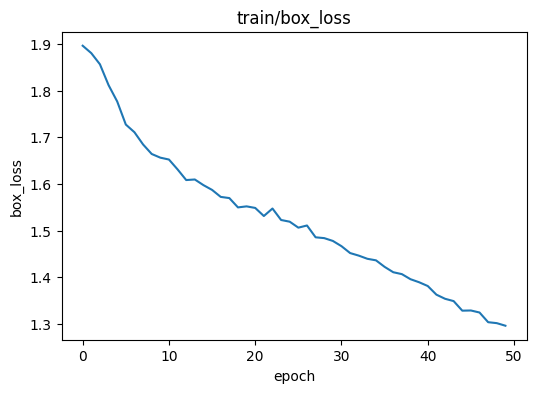

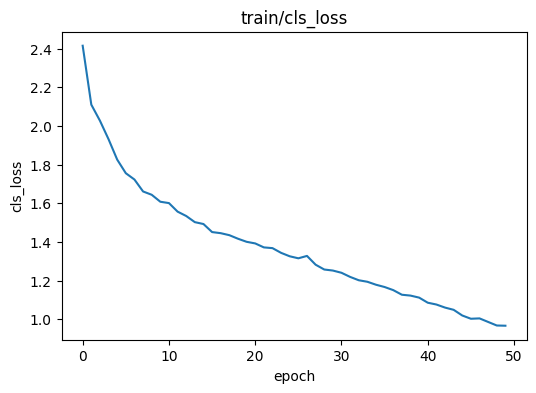

Best weights: /kaggle/working/outputs/yolo_fire_verified/weights/best.pt
Last weights: /kaggle/working/outputs/yolo_fire_verified/weights/last.pt


In [7]:
import os, glob, pandas as pd
import matplotlib.pyplot as plt

# auto-detect the latest run directory
runs = sorted(glob.glob("/kaggle/working/outputs/*/"), key=os.path.getmtime)
assert runs, "No runs found under /kaggle/working/outputs"
run_dir = runs[-1].rstrip("/")
print("Latest run dir:", run_dir)

csv_path = os.path.join(run_dir, "results.csv")
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    for col in ["train/box_loss","train/cls_loss","metrics/mAP50","metrics/mAP50-95"]:
        if col in df.columns:
            plt.figure(figsize=(6,4))
            plt.plot(df[col])
            plt.title(col); plt.xlabel("epoch"); plt.ylabel(col.split("/")[-1])
            plt.show()
else:
    print("results.csv not found in:", run_dir)

print("Best weights:", os.path.join(run_dir, "weights", "best.pt"))
print("Last weights:", os.path.join(run_dir, "weights", "last.pt"))

In [8]:
# Ultralytics draws confusion matrix during val if plots=True by default in recent versions.
# If not present, you can force-plot:
_ = model.val(data=DATA_YAML, imgsz=640, plots=True)
print("Check confusion matrix & PR curves in:", os.path.join(run_dir, "confusion_matrix.png"))

Ultralytics 8.3.225 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1722.7±1022.9 MB/s, size: 80.5 KB)
val: Scanning /kaggle/working/clean_data/val/labels.cache... 3098 images, 1374 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3098/3098 5.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 194/194 13.5it/s 14.4s
                   all       3098       3932      0.752       0.67       0.75      0.436
                  fire       1550       1756      0.783      0.735      0.804      0.498
                 smoke        879       2176      0.721      0.604      0.697      0.374
Speed: 0.6ms preprocess, 1.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2
Check confusion matrix & PR curves in: /kaggle/working/outputs/yolo_fire_verified/confusion_matrix.png
